<a href="https://colab.research.google.com/github/aaronayitey/Sentiment-Analysis-Covid_19-Twitter-Reactions/blob/main/EDA_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Hugging Face

## Application of Hugging Face Text classification model Fune-tuning

In [24]:
# Install packages
!pip install transformers[torch] datasets accelerate -U accelerate>=0.20.1 --upgrade nltk neattext contractions

In [35]:
# Import libraries

import os
import pandas as pd
import re
import neattext.functions as nfx
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import string
import contractions

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [4]:
# Mount drive to load data
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [15]:
# Load the dataset and display some values
df = pd.read_csv('./drive/MyDrive/NLP/data_sent/Train.csv')


df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [16]:
# Check for number of non-null values for each column, the data types and memory usage.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [17]:
# Check for nulls
df.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [18]:
# Get rid of the nulls
df = df[~df.isna().any(axis=1)]

In [19]:
# Take a look at the complete tweet texts for the first five ids.
df.head()['safe_text'].apply(lambda x: print(x))

Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>
I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day
#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD
I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that
Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>


0    None
1    None
2    None
3    None
4    None
Name: safe_text, dtype: object

## Observation

Some texts are in upper case

Some texts have tags unserhandles and hashtags (@/#)

urls and other special characters

In [30]:

def clean_text(text):
    """
    Preprocesses a text string by removing hashtags, user handles, HTML tags, multiple spaces, and converting to lowercase.
    Expands contractions to handle cases like "I'm."

    Parameters:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text with the following operations applied:
            1. Hashtags and user handles removed.
            2. HTML tags removed.
            3. Multiple spaces reduced to a single space.
            4. Text converted to lowercase.
            5. Contractions expanded.
    """

    # Remove hashtags and user handles
    text = nfx.remove_hashtags(text)
    text = nfx.remove_userhandles(text)

    # Remove HTML tags
    text = nfx.remove_html_tags(text)

    # Expand contractions
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Remove extra whitespaces
    text = " ".join(text.split())

    # Convert text to lowercase
    text = text.lower()

    return text


In [31]:
# Invoke function on df['safe_text']
df['safe_text'] = df['safe_text'].apply(clean_text)

In [32]:
# Take a look at the complete tweet texts for the first five ids.
df.head()['safe_text'].apply(lambda x: print(x))

me amp the big homie meanboy3000 stegman st
i am 100 thinking of devoting my career to proving autism is not caused by vaccines due to the idiotic posts i have seen about world autism day
vaccines do not vaccinate your child
i mean if they immunize my kid with something that will not secretly kill him years down the line then i am all for it but i do not trust that
thanks to catch me performing at la nuit nyc 1134 1st ave show starts at 6


0    None
1    None
2    None
3    None
4    None
Name: safe_text, dtype: object

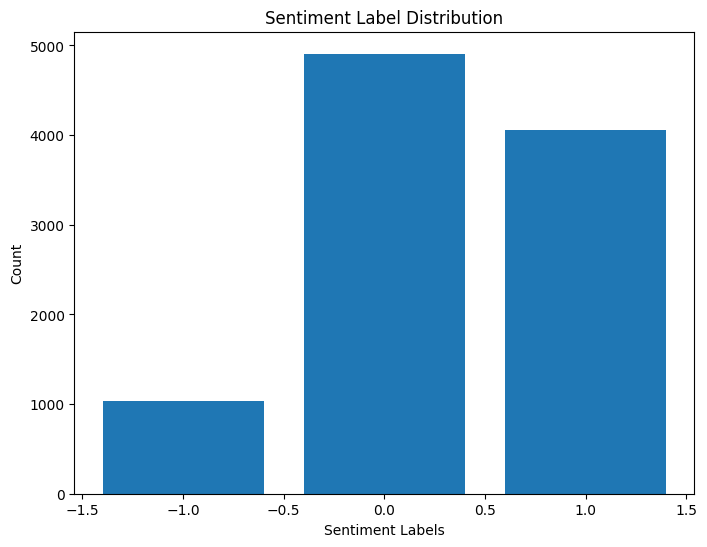

In [34]:
# Assuming 'df' is your DataFrame and 'label' is the column with sentiment labels
sentiment_counts = df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.show()

**`Positive Sentiment (1.0)`**: There are 4,053 instances in your dataset that are labeled as having a positive sentiment. This represents a significant portion of your data and suggests that positive sentiments are well-represented.

**`Neutral Sentiment (0.0)`**: The largest group in your dataset contains 4,908 instances with a neutral sentiment (label 0.0). This indicates a substantial number of tweets with a neutral sentiment.

**`Negative Sentiment (-1.0)`**: There are 1,038 instances with a negative sentiment label (-1.0). While this group is smaller than the positive and neutral categories, it's still a considerable number of negative sentiment tweets.

Here are some considerations based on this label distribution:

Class Imbalance: The dataset appears to have some class imbalance, with neutral and positive sentiments being more prevalent than negative sentiments. This is common in sentiment analysis datasets, as negative sentiments are typically less frequent than neutral or positive ones.

Model Performance: When fine-tuning a sentiment analysis model, it's important to be aware of class imbalance. Depending on the machine learning algorithm and evaluation metrics you use, class imbalance can impact model performance. You might want to consider techniques like oversampling, undersampling, or using class-weighted loss functions to address this imbalance.

Balanced Evaluation: When evaluating the model's performance, it's a good practice to use evaluation metrics that account for class imbalance, such as F1-score, precision, and recall, in addition to accuracy.

Data Quality: Ensure that the data quality and accuracy of label annotations are reliable, as the success of your sentiment analysis model depends on the quality of the labeled data.

## Check the frequency of use of words in our data

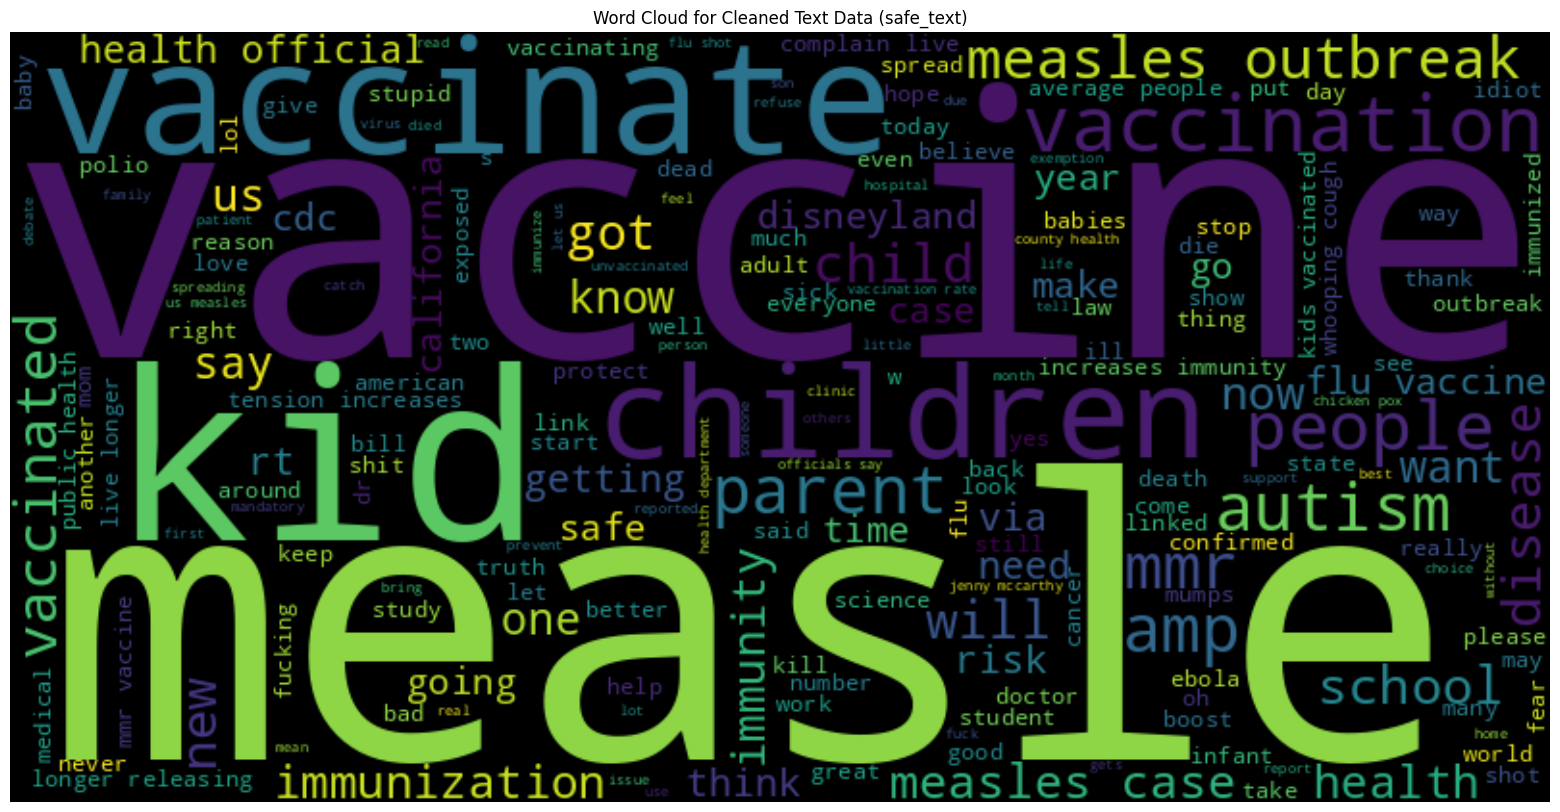

In [39]:
# Collect the cleaned text data from the 'safe_text' column
corpus = ' '.join(df['safe_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(corpus)

# Plot the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cleaned Text Data (safe_text)')
plt.show()